In [ ]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [25]:
def preprocess_features(df, target_col='Class'):
    print(df['Class'].value_counts())
    X = df.drop(columns=[target_col, 'ID', 'Audio Type'], errors='ignore')
    y = df[target_col]

    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].fillna('M')
        X['Sex'] = X['Sex'].map({'M': 0, 'F': 1})

    new_X = pd.DataFrame(index=X.index)

    for col in X.columns:
        def parse_cell(x):
            if isinstance(x, str) and x.startswith('['):
                try:
                    return np.array(json.loads(x.replace('E', 'e')), dtype=float)
                except:
                    return np.nan
            return x

        X[col] = X[col].apply(parse_cell)
        is_array_col = X[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()
        
        if is_array_col:
            sizes = X[col].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 1)
        
            if sizes.nunique() == 1 and sizes.iloc[0] > 1:
                try:
                    list_of_arrays = X[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x).tolist()
                    expanded = pd.DataFrame(list_of_arrays, index=X.index)
                    expanded = expanded.add_prefix(f"{col}_")
                    new_X = pd.concat([new_X, expanded], axis=1)
                except ValueError:
                    new_X[f"{col}_mean"] = X[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else np.nan)
                    new_X[f"{col}_std"] = X[col].apply(lambda x: np.std(x) if isinstance(x, (list, np.ndarray)) else np.nan)
            else:
                new_X[f"{col}_mean"] = X[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else np.nan)
                new_X[f"{col}_std"] = X[col].apply(lambda x: np.std(x) if isinstance(x, (list, np.ndarray)) else np.nan)
        else:
            new_X[col] = X[col]

    new_X = new_X.apply(pd.to_numeric, errors='coerce')
    new_X = new_X.dropna(axis=1, how='all')
    new_X = new_X.fillna(new_X.mean())
    
    return new_X, y

In [26]:
def xgboost(file_path, top_k_features=20):
    print(f"Carregando dataset de: {file_path}")
    try:
        df = pd.read_pickle(file_path)
    except Exception as e:
        print(f"Erro ao carregar o arquivo pickle: {e}")
        return None, None, None

    X, y = preprocess_features(df, target_col='Class')
    
    unique_classes = y.unique()
    class_mapping = {cls: i for i, cls in enumerate(sorted(unique_classes))}
    y_mapped = y.map(class_mapping)
    
    if X.shape[0] == 0 or X.shape[1] == 0:
        print("Erro: Nenhum dado ou feature restante após o pré-processamento.")
        return None, None, None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_mapped, stratify=y_mapped, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    print("Treinando modelo XGBoost...")
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    )
    model.fit(X_train_df, y_train)

    y_pred = model.predict(X_test_df)
    score = f1_score(y_test, y_pred, average='weighted')
    print(f"F1-Weighted: {score:.4f}")

    importances = model.feature_importances_
    feat_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)

    unique_classes = sorted(y.unique())
    class_labels = [str(cls) for cls in unique_classes]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Matriz de Confusão (Conjunto de Teste)")

    cm_filename = "confusion_matrix.png"
    plt.savefig(cm_filename)

    plt.show()
    plt.close()
   
    plot_files = [cm_filename]
        
    top_features = feat_imp['Feature'].iloc[:top_k_features].tolist()
    
    top_features_df = feat_imp.head(top_k_features)
    
    print("\nTop features (baseado na importância do XGBoost):")
    print(top_features_df.to_markdown(index=False))

    return model, top_features_df, score, plot_files

Carregando dataset de: C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\features_task1.pkl
Class
5    856
4    608
3    456
2    208
1     48
Name: count, dtype: int64
Treinando modelo XGBoost...


c:\Users\joaov_zm1q2wh\python\icassp_challenge\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\joaov_zm1q2wh\python\icassp_challenge\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\joaov_zm1q2wh\python\icassp_challenge\.venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\joaov_zm1q2wh\python\icassp_challenge\.venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\joaov_zm1q2wh\python\icassp_challenge\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


F1-Weighted: 0.6419


<Figure size 1000x1000 with 0 Axes>

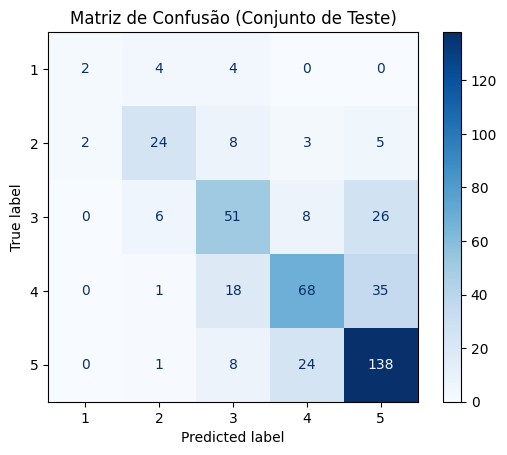


Top features (baseado na importância do XGBoost):
| Feature                      |   Importance |
|:-----------------------------|-------------:|
| duration                     |    0.0340871 |
| duration_without_silence     |    0.0260455 |
| mean_voiced_segment_duration |    0.0254845 |
| frequency                    |    0.0252732 |
| Sex                          |    0.0241743 |
| Age                          |    0.0212531 |
| num_peaks                    |    0.0211592 |
| total_repetitions            |    0.0210126 |
| std_ratio_fundamental        |    0.0209495 |
| peaks_per_sec                |    0.0202057 |
| counts_mean                  |    0.0190538 |
| voicing_rate                 |    0.0189884 |
| median_counts                |    0.0185231 |
| f0_local_variability         |    0.0184209 |
| contrast_energy              |    0.0177351 |
| mean_spectral_slope          |    0.0171843 |
| f0_std                       |    0.0171271 |
| std_ratio_mid                |    0

In [27]:
FILE_PATH = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\features_task1.pkl'

try:
    model, top_features_df, score, plot_files = xgboost(FILE_PATH)

    print("\n## Performance do Modelo")
    print(f"F1-Weighted Score: {score:.4f}\n")
    
    print("## Top Features (baseado na importância do XGBoost)")
    print(tabulate(top_features_df, headers='keys', tablefmt='github', showindex=False))

except Exception as e:
    print(f"Erro fatal durante a execução do script: {e}")

In [ ]:
df = pd.read_csv(r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\joao\data\features_all.csv')

cols_to_drop = [col for col in df.columns if col.startswith("NHR")]
cols_to_drop = [col for col in df.columns if col.startswith("F0_max")]
cols_to_drop = [col for col in df.columns if col.startswith("F0_min")]
# cols_to_drop = [col for col in df.columns if col.startswith("Age")]
# cols_to_drop = [col for col in df.columns if col.startswith("Sex")]

df = df.drop(columns=cols_to_drop)

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

train_df = df[~df["ID"].isin(test_ids)].reset_index(drop=True)
test_df  = df[df["ID"].isin(test_ids)].reset_index(drop=True)

X_train = train_df.drop(columns=["ID", "Class"])
y_train = train_df["Class"]

X_test = test_df.drop(columns=["ID", "Class"])
y_test = test_df["Class"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
y_test_pred  = rf.predict(X_test_scaled)

print("Acurácia treino:", accuracy_score(y_train, y_train_pred))
print("Acurácia teste:", accuracy_score(y_test, y_test_pred))
print("\nRelatório de classificação (teste):")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_test.unique())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()